# Hand written digits recognition with Standard Neural Network

In this notebook we are going to build a standard neural network model to recognize hand written digits using tensorflow.

## Importing packages

In [21]:
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.python.framework import ops
%matplotlib inline

## Loading the data

We will be using the famous MNIST data set of [handwritten digits](http://yann.lecun.com/exdb/mnist/).

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image (28 x 28 pixels).

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

In [6]:
mnist = input_data.read_data_sets('data/', one_hot=True)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


The MNIST data is split into three parts: 55,000 data points of training data (mnist.train), 10,000 points of test data (mnist.test), and 5,000 points of validation data (mnist.validation).

Every MNIST data point has two parts: an image of a handwritten digit and a corresponding label. For example the training images are **mnist.train.images** and the training labels are **mnist.train.labels**.

In [14]:
mnist.train.images.shape

(55000, 784)

Images are flatten into a vector of 28x28 = 784 numbers.

In [15]:
mnist.train.labels.shape

(55000, 10)

The label is a number between 0 and 9 representing the digit drawn in the image. It is a "one-hot vector". A one-hot vector is a vector which is 0 in most dimensions, and 1 in a single dimension.

In [10]:
mnist.test.images.shape

(10000, 784)

In [12]:
mnist.validation.images.shape

(5000, 784)

/home/ibtissem/anaconda/envs/tensorflow/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


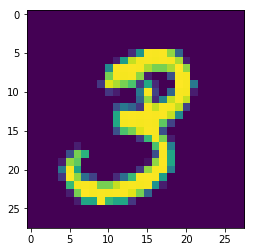

In [9]:
sample=mnist.train.images[1].reshape(28,28)
plt.imshow(sample)

## Building the neural network model in Tensorflow

Let's now define helper functions that we'll need later to build the model.

We'll use two hidden layers with ReLU activation functions. For our output layer we'll use softmaw activation function.

### Network parameters

In [17]:
n_x = 784 # MNIST data input (28*28)
n_y = 10 #MNIST total classes (0-9 digits)
n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 256 # 2nd layer number of features

### Creating placeholders

In [49]:
def create_placeholders (n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (28*28 = 784)
    n_y -- scalar, number of classes (from 0 to 9, so -> 10)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the output labels, of shape [n_y, None] and dtype "float"
    """
    X = tf.placeholder(tf.float32, [n_x, None])
    Y = tf.placeholder(tf.float32, [n_y, None])
    return X, Y
    

### Initializing the parameters

In [62]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow.     
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    W1 = tf.get_variable('W1',[n_hidden_1, n_x], initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable('b1',[n_hidden_1, 1], initializer=tf.zeros_initializer())
    
    W2 = tf.get_variable('w2',[n_hidden_2, n_hidden_1], initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable('b2',[n_hidden_2, 1], initializer=tf.zeros_initializer())
    
    W3 = tf.get_variable('W3',[n_y, n_hidden_2], initializer=tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable('b3',[n_y, 1], initializer=tf.zeros_initializer())
    
    parameters = {'W1':W1, 'b1':b1, 'W2':W2, 'b2':b2, 'W3':W3, 'b3':b3}
    
    return parameters
    

### Forward propagation

The forward propagation stops at Z3. The reason is that in tensorflow the last linear layer output is given as input to the function computing the cost.

In [63]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder
    parameters -- python dictionary containing parameters "W1", "b1", "W2", "b2", "W3", "b3"

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1, (X)),b1)
    A1 = tf.nn.relu(Z1)
    
    Z2 = tf.add(tf.matmul(W2, (A1)),b2)
    A2 = tf.nn.relu(Z2)
    
    Z3 = tf.add(tf.matmul(W3, (A2)),b3)
    
    return Z3

### Compute cost

In [64]:
def compute_cost(Z3, Y):
    """
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (10, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    logits=tf.transpose(Z3)
    labels=tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    return cost
    

The computation of the backpropagation isdone by Tensorflow and this by passing through the tensorflow graph in the reverse order from cost to inputs.

### Building the model

For this model we'll use Adam optimization.

In [65]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.001, num_epochs=20, minibatch_size=64, print_cost=True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- images of the training set
    Y_train -- corresponding labels of the training set
    X_test -- images of the test set
    Y_test -- corresponding labels of the test set
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost
    
    Returns:
    parameters -- parameters learnt by the model.
    """
    ops.reset_default_graph()
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    num_minibatches = int(m/minibatch_size)
    costs = []
    
    X, Y = create_placeholders(n_x, n_y)
    parameters = initialize_parameters()
    
    Z3 = forward_propagation(X, parameters)
    
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init=tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0
            for i in range(num_minibatches):
                (minibatch_x, minibatch_y) = mnist.train.next_batch(minibatch_size)
                _,minibatch_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_x.T, Y:minibatch_y.T})
                epoch_cost= epoch_cost+(minibatch_cost/num_minibatches)
            if print_cost==True:
                print('cost after epoch %i: %f'%(epoch, epoch_cost))
                costs.append(epoch_cost)
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title('learning rate = '+str(learning_rate))
        plt.show
        
        sess.run(parameters) #save the parameters in a variable
        print('parameters have been trained')
        
        correct_predictions = tf.equal(tf.argmax(Z3), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"))
        
        print("train accuracy: ", accuracy.eval({X: X_train, Y: Y_train}))
        print("test accuracy: ", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters 
    

cost after epoch 0: 0.233985
cost after epoch 1: 0.094224
cost after epoch 2: 0.060374
cost after epoch 3: 0.044206
cost after epoch 4: 0.033065
cost after epoch 5: 0.026139
cost after epoch 6: 0.022600
cost after epoch 7: 0.019301
cost after epoch 8: 0.015601
cost after epoch 9: 0.016961
cost after epoch 10: 0.012199
cost after epoch 11: 0.010756
cost after epoch 12: 0.016225
cost after epoch 13: 0.011529
cost after epoch 14: 0.012005
cost after epoch 15: 0.008894
cost after epoch 16: 0.009709
cost after epoch 17: 0.010311
cost after epoch 18: 0.006362
cost after epoch 19: 0.008333
parameters have been trained
train accuracy:  0.998164
test accuracy:  0.9797


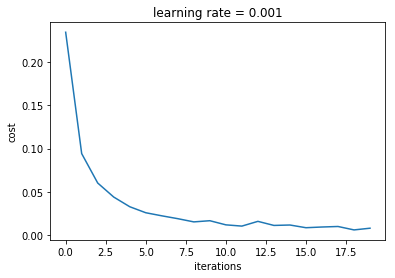

In [66]:
X_train = mnist.train.images.T
Y_train = mnist.train.labels.T
X_test = mnist.test.images.T
Y_test = mnist.test.labels.T
mnist_model = model(X_train, Y_train, X_test, Y_test)

We can add hidden layers, tune the hyperparameters or run for more epochs